# Mamba sampling for a simple linear regression

This notebook is a modification of an example in the documentation of the Mamba package

In [2]:
addprocs(4);
using Compat, Distributions, GraphViz, Mamba, PDMats

First we declare the data

In [3]:
const X = hcat(ones(5),[1.:5]);
const y = [1.,3.,3.,3.,5.];

A simple linear regression model is given in the [Mamba manual](http://mambajl.readthedocs.org/en/latest/) as

In [4]:
model = Model(
  y = Stochastic(1, @modelexpr(μ, σ², MvNormal(μ, √σ²)), false),
  μ = Logical(1, @modelexpr(X, β, XtX, Xty, X * β), false),
  β = Stochastic(1,:(MvNormalCanon(2,0.001))),
  σ² = Stochastic(:(InverseGamma(0.001, 0.001)))
);

The directed acyclic graph (DAG) of the model is

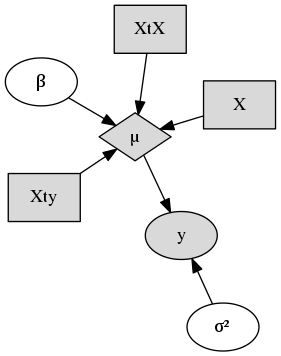

In [5]:
draw(model; filename = "model.dot")
open("model.dot","r") do io Graph(io) end

Because the priors are conjugate we can define explicit samplers.

In [6]:
Gibbs_β = Sampler([:β],
  @modelexpr(β, σ², XtX, Xty,
    begin
      potential = Xty / σ²
      precision = XtX / σ².value + invcov(β.distr)
      rand(MvNormalCanon(potential, precision))
    end
  )
);
Gibbs_σ² = Sampler([:σ²],
  @modelexpr(β, σ², μ, y, 
    begin
      a = length(y) / 2.0 + shape(σ².distr)
      b = sumabs2(y - μ) / 2.0 + scale(σ².distr)
      rand(InverseGamma(a, b))
    end
  )
);
setsamplers!(model,[Gibbs_β, Gibbs_σ²]);

In [7]:
setinputs!(model,
  @compat Dict{Symbol,Any}(:X => X,:XtX => PDMat(X'X), :Xty => X'y));

Set the random number generator seed for reproducibility

In [8]:
srand(1234321);

In [9]:
setinits!(model,
  @compat(Dict{Symbol,Any}(:y=>y,:σ²=>rand(Gamma(1.,1.)),
    :β=>randn(2))));

Now check that the samplers are working as expected.

In [10]:
simulate!(model)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[0.155395,0.933491]
-------------------------------------------------------------------------------
XtX:
PDMat(2,2x2 Array{Float64,2}:
  5.0  15.0
 15.0  55.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 2.23607  6.7082 
 0.0      3.16228)
-------------------------------------------------------------------------------
Xty:
[15.0,53.0]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
0.4592812843144565
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[1.08889,2.02238,2.95587,3.88936,4.82285]
-------------------------------------------------------------------------------
X:
5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3

The initial values, except for the response, `y`, are chosen at random.  There will be 4 chains, each running on a separate process.

In [11]:
inits = [@compat Dict{Symbol,Any}(
    :y => y,
    :β => rand(Normal(0, 1), 2),
    :σ² => rand(Gamma(1, 1))) for i in 1:4]  # 4 chains

4-element Array{Dict{Symbol,Any},1}:
 [:β=>[-0.0156447,0.953986],:σ²=>0.9526895901635107,:y=>[1.0,3.0,3.0,3.0,5.0]]
 [:β=>[1.59606,-2.68816],:σ²=>0.65749993909,:y=>[1.0,3.0,3.0,3.0,5.0]]        
 [:β=>[-0.737157,-1.52248],:σ²=>0.26922686183589084,:y=>[1.0,3.0,3.0,3.0,5.0]]
 [:β=>[0.124493,0.151912],:σ²=>0.490296325781171,:y=>[1.0,3.0,3.0,3.0,5.0]]   

In [12]:
sim = mcmc(model, line, inits, 10000, burnin=2500,
           thin=2, chains=4, verbose=false);

LoadError: line not defined
while loading In[12], in expression starting on line 1

The first time that chains are simulated the various must be compiled.  Once they have been compiled sampling is very fast

In [13]:
@time mcmc(model, line, inits, 10000, 
           burnin=2500, thin=2, chains=4, verbose=false);

LoadError: line not defined
while loading In[13], in expression starting on line 56

In [14]:
describe(sim)

LoadError: sim not defined
while loading In[14], in expression starting on line 1

In [15]:
hpd(sim)

LoadError: sim not defined
while loading In[15], in expression starting on line 1

In [16]:
draw(plot(sim))

LoadError: sim not defined
while loading In[16], in expression starting on line 1